<a href="https://colab.research.google.com/github/tiago121/EAD_geopandas_onde_abrir_cafeteria_belo_horizonte/blob/main/Projeto_cafeteria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CONTEXTO

O objetivo desse projeto é fornecer informações, de forma visual, para a tomada de decisão sobre a melhor localização para um negócio.

Como exemplo, o objetivo específico pretende mostrar qual o melhor local para se abrir uma cafeteria em Belo Horizonte. No entanto, é possível fazer o mesmo processo para praticamente qualquer cidade do Brasil, contanto que os dados sejam íntegros.

Serão usados dados do IBGE para filtrar a concentração de público-alvo nos locais:
* jovens entre 20 e 30 anos;
* pessoas com renda familiar maior do que 5 salários mínimos.

Além disso, será filtrado por locais com alta densidade demográfica e mapeado os principais estabelecimentos da cidade.





## 1 Instalação e importação de pacotes

In [137]:
#!pip install geopandas
#!pip install geocoder
#!pip install descartes

In [138]:
#principais
import pandas as pd
import numpy as np


# visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns


#webscrapping
import requests
from bs4 import BeautifulSoup

#pacotes específicos para geolocalização
import geopandas as gpd
from geopandas import GeoDataFrame
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from shapely.geometry import Polygon
from shapely.geometry import Point



# cores/legendas para gráficos
import matplotlib.cm as cm
import matplotlib.colors as colors

#outros
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler





In [139]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 2 Coleta de dados

### 2.1 Importação dados de geolocalização e demografia do IBGE

Os dados shp (shapefile) foram obtidos por meio do site do IBGE e tiveram um tratamento/modelagem no excel para que estivessem em formato adequado.

In [140]:
df = gpd.read_file('/content/drive/MyDrive/Projeto cafeteria dados/31SEE250GC_SIR.shp')
df_dem = pd.read_csv('/content/drive/MyDrive/Projeto cafeteria dados/Faixa etária_renda_densidade - Página11.csv')
dados_starbucks = pd.read_csv('/content/drive/MyDrive/Projeto cafeteria dados/Faixa etária_renda_densidade - Localização Starbucks (1).csv')


### 2.2 Webscraping

Dados sobre estabelecimentos serão raspados via Apontador, um site que cataloga as principais cafeterias na cidade.

In [141]:
import requests
from bs4 import BeautifulSoup

In [142]:
url = 'https://www.apontador.com.br/em/belo-horizonte-mg/bares-e-restaurantes/cafeterias'
headers = {'User-Agent': "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36"}
site = requests.get(url, headers = headers)
soup = BeautifulSoup(site.content, 'html.parser')



In [143]:


# URL base do site a ser raspado
base_url = "https://www.apontador.com.br/em/belo-horizonte-mg/bares-e-restaurantes/cafeterias"


# Lista para armazenar os dados
data = []

# Loop para iterar sobre as páginas seguintes
page = 1
while page <=10:
    # Constrói a URL da página atual
    url = f"{base_url}?page={page}"

    # Envia uma solicitação GET ao site
    response = requests.get(url)

    # Verifica se a solicitação foi bem-sucedida
    if response.status_code == 200:
        # Cria um objeto BeautifulSoup para analisar o conteúdo HTML da página
        soup = BeautifulSoup(response.content, "html.parser")

        # Encontra todos os elementos h3 na página
        h3_elements = soup.find_all("h3")
        # Encontra todos os elementos com a classe "search-result__address" na página
        address_elements = soup.find_all("div", class_="search-result__address")

        # Itera sobre os elementos h3 e endereços encontrados e imprime o texto
        for i in range(len(h3_elements)):
            #print(h3_elements[i].text, address_elements[i].text.strip())
            cafe_name = h3_elements[i].text
            cafe_address = address_elements[i].text.strip()
            cafe_info = [cafe_name, cafe_address]
            data.append(cafe_info)
            #data.append((f"{h3_elements[i].text},{address_elements[i].text.strip()}"))

        # Incrementa o número da página
        page += 1
    else:
        # Imprime uma mensagem de erro se a solicitação não for bem-sucedida
        print(f"Erro ao acessar a página {url}")
        break

In [144]:
apontador = pd.DataFrame(data, columns=["nome", "endereço"])
apontador.head()

,nome,endereço
0,Gt Cafes,"Avenida Professor Mário Werneck, , Estoril, Be..."
1,Cafeteria da Fazenda,"Rua Montes Claros, 10, Cruzeiro, Belo Horizont..."
2,"Camisa 10 - Restaurante, Bar & Cafeteria","Avenida Cristiano Machado, 11833, Vila Clóris,..."
3,Cafeteria da Fazenda,"Rua Montes Claros, 752, Anchieta, Belo Horizon..."
4,Estação do Café - Funcionários,"Avenida do Contorno, 6548, Santo Antônio, Belo..."


### 2.3 Limpeza de dados raspados

Os dados apresentam  alguns exemplos com mais campos do que pretendidos (rua, número, bairro e cidade) e dados nulos. Será feita a separação nos devidos campos, a realização da limpeza e posterior junção dos dados novamente.

In [145]:
apontador[apontador['nome'] == "Cafeteria Coracoes de Minas"]
apontador = apontador.drop(77)


In [146]:
apontador[apontador['nome'] == "Cafeteria Coracoes de Minas"]

,nome,endereço
89,Cafeteria Coracoes de Minas,"Avenida Pres. Carlos Luz, salao 1140 piso 1, E..."


In [147]:
apontador[['rua', 'numero', 'bairro', 'cidade']] = apontador['endereço'].str.split(',', expand=True)
df1 = apontador.drop(columns="endereço")

In [148]:
df1 = df1.replace(' ', np.nan)
df1.head()

,nome,rua,numero,bairro,cidade
0,Gt Cafes,Avenida Professor Mário Werneck,NaN,Estoril,Belo Horizonte - MG
1,Cafeteria da Fazenda,Rua Montes Claros,10,Cruzeiro,Belo Horizonte - MG
2,"Camisa 10 - Restaurante, Bar & Cafeteria",Avenida Cristiano Machado,11833,Vila Clóris,Belo Horizonte - MG
3,Cafeteria da Fazenda,Rua Montes Claros,752,Anchieta,Belo Horizonte - MG
4,Estação do Café - Funcionários,Avenida do Contorno,6548,Santo Antônio,Belo Horizonte - MG


In [149]:
df1 = df1.dropna()
df1.isna().sum()

nome      0
rua       0
numero    0
bairro    0
cidade    0
dtype: int64

In [150]:
df1['informacoes'] = df1.apply(lambda row: ','.join([str(row['rua']), str(row['numero']),str(row['bairro']), str(row['cidade'])]), axis=1)
df1.head()

,nome,rua,numero,bairro,cidade,informacoes
1,Cafeteria da Fazenda,Rua Montes Claros,10,Cruzeiro,Belo Horizonte - MG,"Rua Montes Claros, 10, Cruzeiro, Belo Horizont..."
2,"Camisa 10 - Restaurante, Bar & Cafeteria",Avenida Cristiano Machado,11833,Vila Clóris,Belo Horizonte - MG,"Avenida Cristiano Machado, 11833, Vila Clóris,..."
3,Cafeteria da Fazenda,Rua Montes Claros,752,Anchieta,Belo Horizonte - MG,"Rua Montes Claros, 752, Anchieta, Belo Horizon..."
4,Estação do Café - Funcionários,Avenida do Contorno,6548,Santo Antônio,Belo Horizonte - MG,"Avenida do Contorno, 6548, Santo Antônio, Belo..."
5,Estação do Café Cafeteria,Avenida Dos Andradas,367 364,Vera Cruz,Belo Horizonte - MG,"Avenida Dos Andradas, 367 364, Vera Cruz, Belo..."


### 2.4 Tranformação de endereços em coordenadas geográficas

Para conseguir plotar os pontos em um gráfico, a fim de entender como estão distribuídos geograficamente, esse passo é necessário.

In [151]:
df2= df1[['informacoes']]
df2

,informacoes
1,"Rua Montes Claros, 10, Cruzeiro, Belo Horizont..."
2,"Avenida Cristiano Machado, 11833, Vila Clóris,..."
3,"Rua Montes Claros, 752, Anchieta, Belo Horizon..."
4,"Avenida do Contorno, 6548, Santo Antônio, Belo..."
5,"Avenida Dos Andradas, 367 364, Vera Cruz, Belo..."
...,...
90,"Praça Creta, 39, Europa, Belo Horizonte - MG"
91,"Rua Bernardo Guimarães, 1037, Funcionários, Be..."
92,"Rua dos Goitacazes, 1543, Barro Preto, Belo Ho..."
93,"Avenida Augusto de Lima, 744, Centro, Belo Hor..."


In [152]:
locator = Nominatim(user_agent = "myGeocoder")
location = locator.geocode('df_teste')
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

In [153]:
df1['informacoes_geo'] = df1['informacoes'].apply(geocode)
df1['lat'] = df1['informacoes_geo'].apply(lambda loc: loc.latitude if loc else None)
df1['lon'] = df1['informacoes_geo'].apply(lambda loc: loc.longitude if loc else None)

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/urllib3/connectionpool.py", line 449, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/usr/local/lib/python3.9/dist-packages/urllib3/connectionpool.py", line 444, in _make_request
    httplib_response = conn.getresponse()
  File "/usr/lib/python3.9/http/client.py", line 1377, in getresponse
    response.begin()
  File "/usr/lib/python3.9/http/client.py", line 320, in begin
    version, status, reason = self._read_status()
  File "/usr/lib/python3.9/http/client.py", line 281, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/usr/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "/usr/lib/python3.9/ssl.py", line 1242, in recv_into
    return self.read(nbytes, buffer)
  File "/usr/lib/python3.9/ssl.py", line 1100, in read
    return self._sslobj.read(len, buffer)
socket.timeout: The read 

In [154]:
df1 = df1.dropna()
df1.isna().sum()

nome               0
rua                0
numero             0
bairro             0
cidade             0
informacoes        0
informacoes_geo    0
lat                0
lon                0
dtype: int64

In [155]:
apontador = df1

## 3 Descrição e limpeza de dados

### 3.1 Descrevendo os dados

Os dados que temos são:

 - df: dados de geolocalização por bairro para a cidade de BH
 - df_dem: dados demográficos por bairro de renda, faixa etária e densidade
 - local: dados com cafeterias Starbucks (coletados do Google Maps com GoogleMaps Extractor
 - apontador: dados de outras cafeterias coletador via webscraping

In [156]:
df.head(3)

,ID,CD_GEOCODI,TIPO,CD_GEOCODB,NM_BAIRRO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,geometry
0,1,310010405000011,RURAL,NaN,NaN,31001040500,NaN,310010405,ABADIA DOS DOURADOS,3100104,ABADIA DOS DOURADOS,PATROCÍNIO,TRIÂNGULO MINEIRO/ALTO PARANAÍBA,"POLYGON ((-47.57649 -18.22600, -47.57596 -18.2..."
1,2,310010405000012,RURAL,NaN,NaN,31001040500,NaN,310010405,ABADIA DOS DOURADOS,3100104,ABADIA DOS DOURADOS,PATROCÍNIO,TRIÂNGULO MINEIRO/ALTO PARANAÍBA,"POLYGON ((-47.42967 -18.16543, -47.42943 -18.1..."
2,3,310010405000013,RURAL,NaN,NaN,31001040500,NaN,310010405,ABADIA DOS DOURADOS,3100104,ABADIA DOS DOURADOS,PATROCÍNIO,TRIÂNGULO MINEIRO/ALTO PARANAÍBA,"POLYGON ((-47.42649 -18.29056, -47.42643 -18.2..."


In [157]:
df.columns

Index(['ID', 'CD_GEOCODI', 'TIPO', 'CD_GEOCODB', 'NM_BAIRRO', 'CD_GEOCODS',
       'NM_SUBDIST', 'CD_GEOCODD', 'NM_DISTRIT', 'CD_GEOCODM', 'NM_MUNICIP',
       'NM_MICRO', 'NM_MESO', 'geometry'],
      dtype='object')

In [158]:
df.head(2)

,ID,CD_GEOCODI,TIPO,CD_GEOCODB,NM_BAIRRO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,geometry
0,1,310010405000011,RURAL,NaN,NaN,31001040500,NaN,310010405,ABADIA DOS DOURADOS,3100104,ABADIA DOS DOURADOS,PATROCÍNIO,TRIÂNGULO MINEIRO/ALTO PARANAÍBA,"POLYGON ((-47.57649 -18.22600, -47.57596 -18.2..."
1,2,310010405000012,RURAL,NaN,NaN,31001040500,NaN,310010405,ABADIA DOS DOURADOS,3100104,ABADIA DOS DOURADOS,PATROCÍNIO,TRIÂNGULO MINEIRO/ALTO PARANAÍBA,"POLYGON ((-47.42967 -18.16543, -47.42943 -18.1..."


In [159]:
df_dem.head(2)

,Bairro,mais de 5 salários,Faixa etária,Densidade
0,Vila Rica,23.04,12.57,6897
1,Vila do Pombal,2.46,13.93,35500


In [160]:
dados_starbucks.head(2)

,Name,Fulladdress,Bairro,Municipality,Review Count,Average Rating,Latitude,Longitude
0,Starbucks Boulevard Shopping,"Av. dos Andradas - Santa Efigênia, Belo Horizo...",Santa Efigênia,Belo Horizonte - MG,444,3.9,-19.92,-43.91
1,Starbucks,"BR-356, 3049 - Belvedere, Belo Horizonte - MG,...",Belvedere,Belo Horizonte - MG,143,3.5,-19.97,-43.94


In [161]:
apontador.head(2)

,nome,rua,numero,bairro,cidade,informacoes,informacoes_geo,lat,lon
1,Cafeteria da Fazenda,Rua Montes Claros,10,Cruzeiro,Belo Horizonte - MG,"Rua Montes Claros, 10, Cruzeiro, Belo Horizont...","(Rua Montes Claros, Marimbá, Vianópolis, Betim...",-19.919193,-44.277980
2,"Camisa 10 - Restaurante, Bar & Cafeteria",Avenida Cristiano Machado,11833,Vila Clóris,Belo Horizonte - MG,"Avenida Cristiano Machado, 11833, Vila Clóris,...","(11833, Avenida Cristiano Machado, Parque São ...",-19.820676,-43.946807


### 3.2 Filtragem dados

In [162]:
df_bh = df[df['NM_MUNICIP'] == 'BELO HORIZONTE']

In [163]:
df_bh.head(10)

,ID,CD_GEOCODI,TIPO,CD_GEOCODB,NM_BAIRRO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,geometry
732,978,310620005620091,URBANO,310620005088,Boa Viagem,31062000562,CENTRO-SUL,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.93512 -19.92652, -43.93421 -19.9..."
733,979,310620005620092,URBANO,310620005083,Centro,31062000562,CENTRO-SUL,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.93521 -19.91865, -43.93503 -19.9..."
734,980,310620005620093,URBANO,310620005010,Floresta,31062000562,CENTRO-SUL,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.93066 -19.91782, -43.93014 -19.9..."
735,981,310620005620094,URBANO,310620005010,Floresta,31062000562,CENTRO-SUL,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.92944 -19.91711, -43.92892 -19.9..."
736,982,310620005620095,URBANO,310620005010,Floresta,31062000562,CENTRO-SUL,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.92735 -19.91801, -43.92698 -19.9..."
737,983,310620005620096,URBANO,310620005093,Nossa Senhora da Aparecida,31062000562,CENTRO-SUL,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.91973 -19.92848, -43.91953 -19.9..."
738,984,310620005620097,URBANO,310620005093,Nossa Senhora da Aparecida,31062000562,CENTRO-SUL,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.91906 -19.93043, -43.91895 -19.9..."
739,985,310620005620415,URBANO,310620005090,Santo Agostinho,31062000562,CENTRO-SUL,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.95298 -19.93128, -43.95169 -19.9..."
740,986,310620005620416,URBANO,310620005102,Santa Lúcia,31062000562,CENTRO-SUL,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.94630 -19.96612, -43.94595 -19.9..."
741,987,310620005620417,URBANO,310620005102,Santa Lúcia,31062000562,CENTRO-SUL,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.94989 -19.95967, -43.94978 -19.9..."


In [164]:
df_bh[['NM_BAIRRO']].value_counts()

NM_BAIRRO      
Sagrada Família    58
Padre Eustáquio    51
Lourdes            37
Centro             36
Buritis            36
                   ..
Santa Isabel        1
Satelite            1
Sumaré              1
São Damião          1
Ápia                1
Length: 486, dtype: int64

### 3.3 Renomeando colunas

In [165]:
df_dem = df_dem.rename(columns={'Faixa etária': 'faixa_etaria'})
df_dem.head()

,Bairro,mais de 5 salários,faixa_etaria,Densidade
0,Vila Rica,23.04,12.57,6897
1,Vila do Pombal,2.46,13.93,35500
2,Cidade Jardim Taquaril,17.20,14.65,83
3,Vila Batik,0.00,15.24,16000
4,Pirineus,10.46,15.59,1235


In [166]:
df_dem = df_dem.rename(columns={'mais de 5 salários': 'renda'})
df_dem.head()

,Bairro,renda,faixa_etaria,Densidade
0,Vila Rica,23.04,12.57,6897
1,Vila do Pombal,2.46,13.93,35500
2,Cidade Jardim Taquaril,17.20,14.65,83
3,Vila Batik,0.00,15.24,16000
4,Pirineus,10.46,15.59,1235


### 3.4 Junção  e limpeza de dados para plotar mapas

In [167]:
df_dem = df_dem.rename(columns={'Bairro': 'NM_BAIRRO'})

In [168]:
df_dem.head()

,NM_BAIRRO,renda,faixa_etaria,Densidade
0,Vila Rica,23.04,12.57,6897
1,Vila do Pombal,2.46,13.93,35500
2,Cidade Jardim Taquaril,17.20,14.65,83
3,Vila Batik,0.00,15.24,16000
4,Pirineus,10.46,15.59,1235


In [169]:
# fazer o merge entre os datasets


aux = pd.merge( df_bh, df_dem, how='inner', on='NM_BAIRRO' )

In [170]:
aux.columns

Index(['ID', 'CD_GEOCODI', 'TIPO', 'CD_GEOCODB', 'NM_BAIRRO', 'CD_GEOCODS',
       'NM_SUBDIST', 'CD_GEOCODD', 'NM_DISTRIT', 'CD_GEOCODM', 'NM_MUNICIP',
       'NM_MICRO', 'NM_MESO', 'geometry', 'renda', 'faixa_etaria',
       'Densidade'],
      dtype='object')

In [171]:
aux.isna().sum()

ID              0
CD_GEOCODI      0
TIPO            0
CD_GEOCODB      0
NM_BAIRRO       0
CD_GEOCODS      0
NM_SUBDIST      0
CD_GEOCODD      0
NM_DISTRIT      0
CD_GEOCODM      0
NM_MUNICIP      0
NM_MICRO        0
NM_MESO         0
geometry        0
renda           0
faixa_etaria    3
Densidade       0
dtype: int64

In [172]:
aux = aux.fillna(0)

In [173]:
aux.isna().sum()

ID              0
CD_GEOCODI      0
TIPO            0
CD_GEOCODB      0
NM_BAIRRO       0
CD_GEOCODS      0
NM_SUBDIST      0
CD_GEOCODD      0
NM_DISTRIT      0
CD_GEOCODM      0
NM_MUNICIP      0
NM_MICRO        0
NM_MESO         0
geometry        0
renda           0
faixa_etaria    0
Densidade       0
dtype: int64

In [174]:
aux.dtypes

ID                 int64
CD_GEOCODI        object
TIPO              object
CD_GEOCODB        object
NM_BAIRRO         object
CD_GEOCODS        object
NM_SUBDIST        object
CD_GEOCODD        object
NM_DISTRIT        object
CD_GEOCODM        object
NM_MUNICIP        object
NM_MICRO          object
NM_MESO           object
geometry        geometry
renda            float64
faixa_etaria     float64
Densidade          int64
dtype: object

In [175]:
aux1 = aux.sort_values(by=['Densidade'], ascending=False)
aux1.head()

,ID,CD_GEOCODI,TIPO,CD_GEOCODB,NM_BAIRRO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,geometry,renda,faixa_etaria,Densidade
2535,4251,310620005680045,URBANO,310620005289,Vila Aeroporto Jaraguá,31062000568,PAMPULHA,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.95888 -19.85588, -43.95872 -19.8...",0.76,23.38,61800
2504,4223,310620005680017,URBANO,310620005237,Vila Paquetá,31062000568,PAMPULHA,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.99360 -19.86603, -43.99345 -19.8...",0.00,25.50,58583
939,2639,310620005630140,URBANO,310620005045,Vila União,31062000563,LESTE,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.91937 -19.91980, -43.91842 -19.9...",1.09,26.28,54286
2650,4333,310620005680127,URBANO,310620005171,Vila Santa Rosa,31062000568,PAMPULHA,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.95187 -19.87008, -43.95117 -19.8...",0.00,23.04,49679
2651,4468,310620005680262,URBANO,310620005171,Vila Santa Rosa,31062000568,PAMPULHA,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.95025 -19.87325, -43.95005 -19.8...",0.00,23.04,49679


In [176]:
aux.head(2)

,ID,CD_GEOCODI,TIPO,CD_GEOCODB,NM_BAIRRO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,geometry,renda,faixa_etaria,Densidade
0,978,310620005620091,URBANO,310620005088,Boa Viagem,31062000562,CENTRO-SUL,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.93512 -19.92652, -43.93421 -19.9...",38.9,27.5,19421
1,977,310620005620090,URBANO,310620005088,Boa Viagem,31062000562,CENTRO-SUL,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.93512 -19.92652, -43.93411 -19.9...",38.9,27.5,19421


## 4 Plotagem dos mapas (análise geográfica exploratória)

A ideia é plotar os mapas com a concentração de  cada característica (faixa_etaria, renda e densidade) na cidade, indicando se há algum local específico que se destaca.

### 4.1 Faixa etária

#### 4.1.1 Achar o bairro com maior faixa-etária

In [177]:
aux.sort_values(by=['faixa_etaria'],ascending=False ).head(5)


,ID,CD_GEOCODI,TIPO,CD_GEOCODB,NM_BAIRRO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,geometry,renda,faixa_etaria,Densidade
2075,3587,310620005650429,URBANO,310620005253,Vila Puc,31062000565,NOROESTE,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.99432 -19.92086, -43.99443 -19.9...",6.25,35.00,22250
2555,4261,310620005680055,URBANO,310620005269,Indaiá,31062000568,PAMPULHA,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.95057 -19.86095, -43.95031 -19.8...",20.95,30.25,7625
2556,4262,310620005680056,URBANO,310620005269,Indaiá,31062000568,PAMPULHA,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.95234 -19.86233, -43.95226 -19.8...",20.95,30.25,7625
2557,4401,310620005680195,URBANO,310620005269,Indaiá,31062000568,PAMPULHA,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.95534 -19.86567, -43.95496 -19.8...",20.95,30.25,7625
2558,4402,310620005680196,URBANO,310620005269,Indaiá,31062000568,PAMPULHA,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.95452 -19.86399, -43.95417 -19.8...",20.95,30.25,7625


In [178]:

top_faixa_etaria = aux[~aux['NM_BAIRRO'].duplicated(keep='first')].sort_values(by=['faixa_etaria'],ascending=False ).head(1)



In [179]:
top_faixa_etaria 

,ID,CD_GEOCODI,TIPO,CD_GEOCODB,NM_BAIRRO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,geometry,renda,faixa_etaria,Densidade
2075,3587,310620005650429,URBANO,310620005253,Vila Puc,31062000565,NOROESTE,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.99432 -19.92086, -43.99443 -19.9...",6.25,35.0,22250


#### 4.1.2 Achar os centroides de cada polígono

In [180]:

# função que retorna o centroide de um polígono
def calcular_centroide(poligono):
    return poligono.centroid

# aplicar a função para criar a nova coluna "centroide"
top_faixa_etaria['centroide'] = top_faixa_etaria['geometry'].apply(calcular_centroide)

# imprimir o DataFrame resultante
display(top_faixa_etaria)

,ID,CD_GEOCODI,TIPO,CD_GEOCODB,NM_BAIRRO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,geometry,renda,faixa_etaria,Densidade,centroide
2075,3587,310620005650429,URBANO,310620005253,Vila Puc,31062000565,NOROESTE,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.99432 -19.92086, -43.99443 -19.9...",6.25,35.0,22250,POINT (-43.99458 -19.92025)


#### 4.1.3 Plotar o Mapa

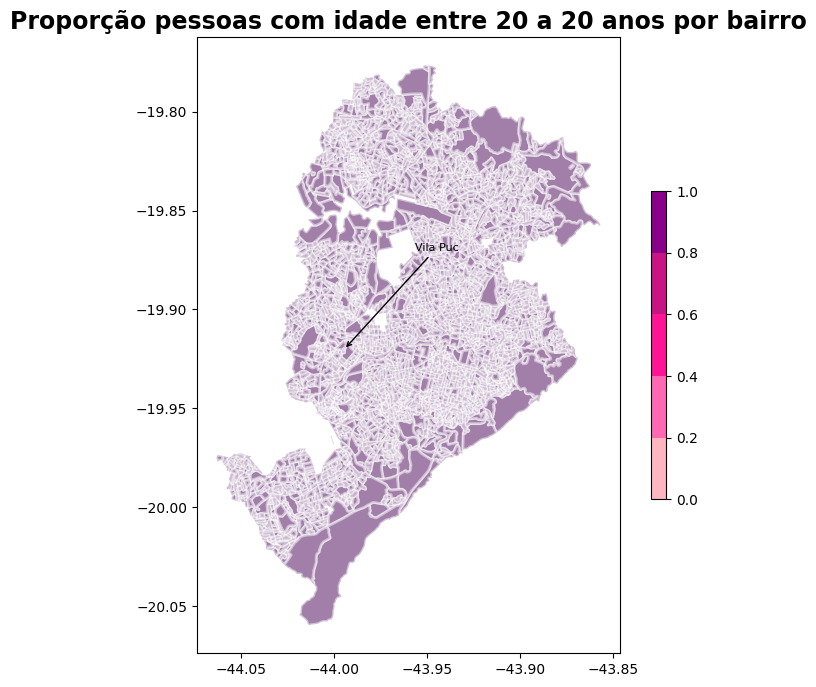

In [181]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

#plt.title('Map 1 - Proporção de pessoas com 5 salários mínimos ou mais', size=17, weight='heavy')
#mapa_cores = aux.plot(column='faixa_etaria', cmap='Spectral',
#                       edgecolor='white', linewidth=2, ax=ax, alpha=0.8)

plt.title('Proporção pessoas com idade entre 20 a 20 anos por bairro', size=17, weight='heavy')

# define o valor mínimo e máximo para a escala de cores
vmin = aux['Densidade'].min()
vmax = aux['Densidade'].max()

# cria a escala de cores

wine_colormap = colors.ListedColormap(['#FFB6C1', '#FF69B4', '#FF1493', '#C71585', '#8B008B'])

mapa_cores = aux.plot(column='faixa_etaria', cmap='viridis', edgecolor='white',
                       linewidth=2, ax=ax, alpha=0.5, vmin=vmin, vmax=vmax)


# criação da legenda

mapa_cores = cm.ScalarMappable(cmap=wine_colormap)
#mapa_cores.set_array([-19.75, maximo])
legenda = plt.colorbar(mapa_cores, ax=ax, shrink=0.5)
#legenda.ax.set_ylabel('Proporção de adultos')


def plot_annotate(name, xy, xytext, color='black'):
    ax.annotate(text=name, xy=xy, xytext=xytext, size=8, arrowprops=dict(arrowstyle="->", color=color), 
                horizontalalignment='center', color=color)
    

for index, row in top_faixa_etaria.iterrows():
    poligono = row['geometry']
    centroide = row['centroide']
    cor = 'red' if index == 0 else 'black' # definir uma cor diferente para o primeiro polígono
    #ax.add_patch(plt.Polygon(poligono.exterior, facecolor='none', edgecolor=cor, linewidth=2))
    plot_annotate(name=row['NM_BAIRRO'], xy=centroide.coords[0], xytext=(centroide.x + 0.05, centroide.y + 0.05), color=cor)



plt.show()

#### 4.1.4  Insights faixa etária

 - O bairro com maior % de pessoas do público-alvo é o Vila Puc, com 35% entre 20 e 30 anos.
 - A população de 20 a 30 anos está bem espalhada pela cidade, mas há areas específicas que são interessantes de serem observadas.

###4.2 Renda

#### 4.2.1 Achar o bairro com maior renda

In [182]:
top_renda = aux[~aux['NM_BAIRRO'].duplicated(keep='first')].sort_values(by=['renda'],ascending=False ).head(3)


In [183]:
top_renda

,ID,CD_GEOCODI,TIPO,CD_GEOCODB,NM_BAIRRO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,geometry,renda,faixa_etaria,Densidade
473,2047,310620005620012,URBANO,310620005087,Savassi,31062000562,CENTRO-SUL,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.93006 -19.93822, -43.92877 -19.9...",49.19,19.97,9926
171,991,310620005620421,URBANO,310620005101,Belvedere,31062000562,CENTRO-SUL,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.94295 -19.96799, -43.94277 -19.9...",48.69,17.98,3022
788,2394,310620005620367,URBANO,310620005108,Luxemburgo,31062000562,CENTRO-SUL,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.95557 -19.95009, -43.95519 -19.9...",47.91,19.37,10309


#### 4.2.2 Achar centróides

In [184]:
# função que retorna o centroide de um polígono
def calcular_centroide(poligono):
    return poligono.centroid

# aplicar a função para criar a nova coluna "centroide"
top_renda['centroide'] = top_renda['geometry'].apply(calcular_centroide)

# imprimir o DataFrame resultante
display(top_renda)

,ID,CD_GEOCODI,TIPO,CD_GEOCODB,NM_BAIRRO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,geometry,renda,faixa_etaria,Densidade,centroide
473,2047,310620005620012,URBANO,310620005087,Savassi,31062000562,CENTRO-SUL,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.93006 -19.93822, -43.92877 -19.9...",49.19,19.97,9926,POINT (-43.92892 -19.93898)
171,991,310620005620421,URBANO,310620005101,Belvedere,31062000562,CENTRO-SUL,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.94295 -19.96799, -43.94277 -19.9...",48.69,17.98,3022,POINT (-43.94326 -19.97075)
788,2394,310620005620367,URBANO,310620005108,Luxemburgo,31062000562,CENTRO-SUL,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.95557 -19.95009, -43.95519 -19.9...",47.91,19.37,10309,POINT (-43.95623 -19.95122)


#### 4.2.3 Plotar o mapa

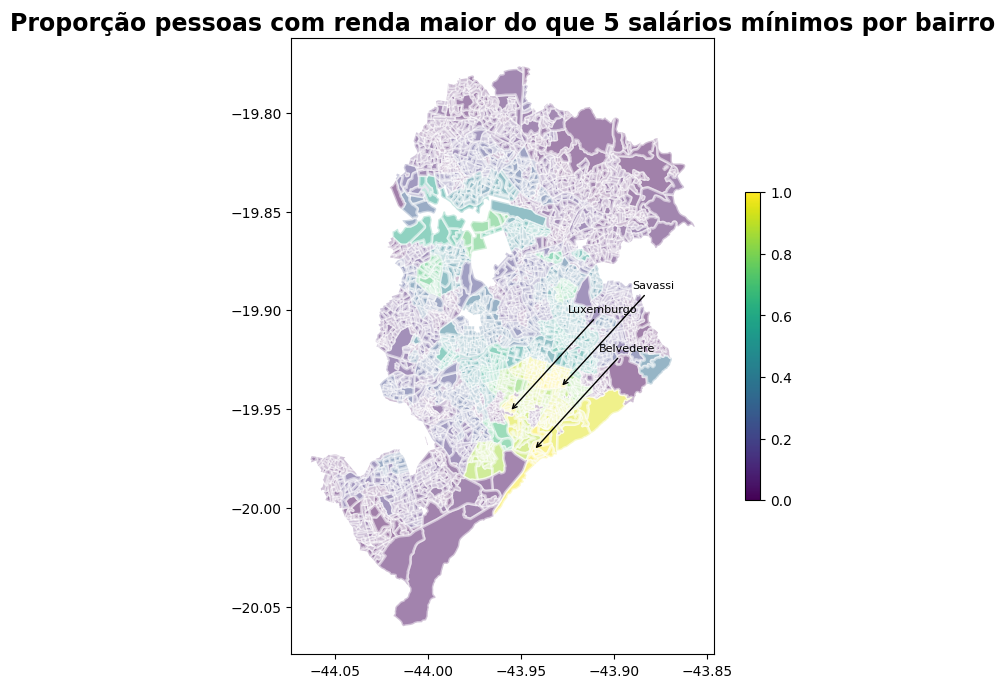

In [185]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

#plt.title('Map 1 - Proporção de pessoas com 5 salários mínimos ou mais', size=17, weight='heavy')
#mapa_cores = aux.plot(column='faixa_etaria', cmap='Spectral',
#                       edgecolor='white', linewidth=2, ax=ax, alpha=0.8)

plt.title('Proporção pessoas com renda maior do que 5 salários mínimos por bairro', size=17, weight='heavy')

# define o valor mínimo e máximo para a escala de cores
vmin = aux['renda'].min()
vmax = aux['renda'].max()

# cria a escala de cores
wine_colormap = colors.ListedColormap(['#FFB6C1', '#FF69B4', '#FF1493', '#C71585', '#8B008B'])

mapa_cores = aux.plot(column='renda', cmap='viridis', edgecolor='white',
                       linewidth=2, ax=ax, alpha=0.5, vmin=vmin, vmax=vmax)


# criação da legenda
mapa_cores = cm.ScalarMappable(cmap='viridis')
#mapa_cores.set_array([-19.75, maximo])
legenda = plt.colorbar(mapa_cores, ax=ax, shrink=0.5)
#legenda.ax.set_ylabel('Proporção de adultos')


def plot_annotate(name, xy, xytext, color='black'):
    ax.annotate(text=name, xy=xy, xytext=xytext, size=8, arrowprops=dict(arrowstyle="->", color=color), 
                horizontalalignment='center', color=color)
    

for index, row in top_renda.iterrows():
    poligono = row['geometry']
    centroide = row['centroide']
    cor = 'red' if index == 0 else 'black' # definir uma cor diferente para o primeiro polígono
    #ax.add_patch(plt.Polygon(poligono.exterior, facecolor='none', edgecolor=cor, linewidth=2))
    plot_annotate(name=row['NM_BAIRRO'], xy=centroide.coords[0], xytext=(centroide.x + 0.05, centroide.y + 0.05), color=cor)



plt.show()

#### 4.2.4 Insights renda

 - O bairro com maior % de pessoas do público-alvo é o Savassi, com 35% entre 20 e 30 anos, seguida por Belvedere e Luxemburgo.
 - OS bairros com maior renda se concentram na parte sudeste, tendo regiões secundárias a noroeste.

### 4.3 Densidade

#### 4.3.1 Achar bairro com maior densidade

In [186]:
top_densidade = aux[~aux['NM_BAIRRO'].duplicated(keep='first')].sort_values(by=['Densidade'],ascending=False ).head(3)


#### 4.3.2 Achar centroides

In [187]:
# função que retorna o centroide de um polígono
def calcular_centroide(poligono):
    return poligono.centroid

# aplicar a função para criar a nova coluna "centroide"
top_densidade['centroide'] = top_densidade['geometry'].apply(calcular_centroide)

# imprimir o DataFrame resultante
display(top_densidade)

,ID,CD_GEOCODI,TIPO,CD_GEOCODB,NM_BAIRRO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,geometry,renda,faixa_etaria,Densidade,centroide
2535,4251,310620005680045,URBANO,310620005289,Vila Aeroporto Jaraguá,31062000568,PAMPULHA,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.95888 -19.85588, -43.95872 -19.8...",0.76,23.38,61800,POINT (-43.95858 -19.85650)
2504,4223,310620005680017,URBANO,310620005237,Vila Paquetá,31062000568,PAMPULHA,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.99360 -19.86603, -43.99345 -19.8...",0.00,25.50,58583,POINT (-43.99345 -19.86634)
939,2639,310620005630140,URBANO,310620005045,Vila União,31062000563,LESTE,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.91937 -19.91980, -43.91842 -19.9...",1.09,26.28,54286,POINT (-43.91886 -19.92039)


In [188]:
top_densidade.dtypes

ID                 int64
CD_GEOCODI        object
TIPO              object
CD_GEOCODB        object
NM_BAIRRO         object
CD_GEOCODS        object
NM_SUBDIST        object
CD_GEOCODD        object
NM_DISTRIT        object
CD_GEOCODM        object
NM_MUNICIP        object
NM_MICRO          object
NM_MESO           object
geometry        geometry
renda            float64
faixa_etaria     float64
Densidade          int64
centroide       geometry
dtype: object

#### 4.3.2 Plotar o mapa

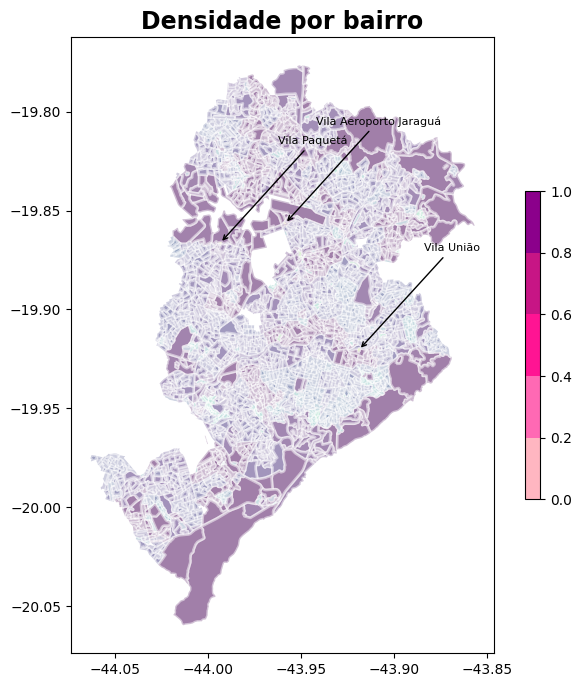

In [189]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

#plt.title('Map 1 - Proporção de pessoas com 5 salários mínimos ou mais', size=17, weight='heavy')
#mapa_cores = aux.plot(column='faixa_etaria', cmap='Spectral',
#                       edgecolor='white', linewidth=2, ax=ax, alpha=0.8)

plt.title('Densidade por bairro', size=17, weight='heavy')

# define o valor mínimo e máximo para a escala de cores
vmin = aux['Densidade'].min()
vmax = aux['Densidade'].max()

# cria a escala de cores
wine_colormap = colors.ListedColormap(['#FFB6C1', '#FF69B4', '#FF1493', '#C71585', '#8B008B'])

mapa_cores = aux.plot(column='Densidade', cmap='viridis', edgecolor='white',
                       linewidth=2, ax=ax, alpha=0.5, vmin=vmin, vmax=vmax)


# criação da legenda
mapa_cores = cm.ScalarMappable(cmap=wine_colormap)
#mapa_cores.set_array([-19.75, maximo])
legenda = plt.colorbar(mapa_cores, ax=ax, shrink=0.5)
#legenda.ax.set_ylabel('Proporção de adultos')


def plot_annotate(name, xy, xytext, color='black'):
    ax.annotate(text=name, xy=xy, xytext=xytext, size=8, arrowprops=dict(arrowstyle="->", color=color), 
                horizontalalignment='center', color=color)
    

for index, row in top_densidade.iterrows():
    poligono = row['geometry']
    centroide = row['centroide']
    cor = 'red' if index == 0 else 'black' # definir uma cor diferente para o primeiro polígono
    #ax.add_patch(plt.Polygon(poligono.exterior, facecolor='none', edgecolor=cor, linewidth=2))
    plot_annotate(name=row['NM_BAIRRO'], xy=centroide.coords[0], xytext=(centroide.x + 0.05, centroide.y + 0.05), color=cor)



plt.show()

#### 4.3.3 Insights densidade

 - Os bairros de maior densidade se concentram na região noroeste, mas estão bem espalhados.


## 5 Criação do ranking de bairros

### 5.1 Normalização dos dados

In [190]:
df_dem.head(2)

,NM_BAIRRO,renda,faixa_etaria,Densidade
0,Vila Rica,23.04,12.57,6897
1,Vila do Pombal,2.46,13.93,35500


In [191]:
# Instanciando o scaler MinMax
scaler = MinMaxScaler()

In [192]:
bairros = df_dem['NM_BAIRRO']
dados = df_dem.drop('NM_BAIRRO', axis=1)

In [193]:
dados.head(2)

,renda,faixa_etaria,Densidade
0,23.04,12.57,6897
1,2.46,13.93,35500


In [194]:
# Normalizando os dados
dados_norm = scaler.fit_transform(dados)

# Criando um novo DataFrame com os dados normalizados
df_norm = pd.DataFrame(dados_norm, columns=dados.columns)

# Concatenando a coluna "NM_BAIRRO" com o novo DataFrame
df_norm = pd.concat([bairros, df_norm], axis=1)



In [195]:
df_norm

,NM_BAIRRO,renda,faixa_etaria,Densidade
0,Vila Rica,0.468388,0.000000,0.111602
1,Vila do Pombal,0.050010,0.060633,0.574434
2,Cidade Jardim Taquaril,0.349665,0.092733,0.001343
3,Vila Batik,0.000000,0.119037,0.258900
4,Pirineus,0.212645,0.134641,0.019984
...,...,...,...,...
476,Maravilha,0.081317,0.777084,0.226537
477,Indaiá,0.425900,0.788230,0.123382
478,Vila Puc,0.127058,1.000000,0.360032
479,Xangri-lá,0.000000,NaN,0.000243


### 5.2 Construção tabelas heatmap ordenada, com média ponderada e gráfico

In [196]:
df_norm.head(20).style.background_gradient(subset=['renda','faixa_etaria',
                                               'Densidade',], cmap='coolwarm_r')

,NM_BAIRRO,renda,faixa_etaria,Densidade
0,Vila Rica,0.468388,0.000000,0.111602
1,Vila do Pombal,0.050010,0.060633,0.574434
2,Cidade Jardim Taquaril,0.349665,0.092733,0.001343
3,Vila Batik,0.000000,0.119037,0.258900
4,Pirineus,0.212645,0.134641,0.019984
5,Pindura Saia,0.075828,0.138208,0.618932
6,Vila São Francisco,0.000000,0.143558,0.372168
7,Campo Alegre,0.098191,0.153812,0.207006
8,Braúnas,0.280748,0.156487,0.016408
9,Vila Fumec,0.098394,0.158716,0.388350


In [197]:
df_norm['ponderada'] = (2 * df_norm['renda'] +  2 * df_norm['faixa_etaria'] +   df_norm['Densidade']) / 3

In [198]:
df_norm = df_norm.sort_values(by='ponderada', ascending=False)
df_norm = df_norm.head(20)

### 5.3 Comparação entre os principais bairros

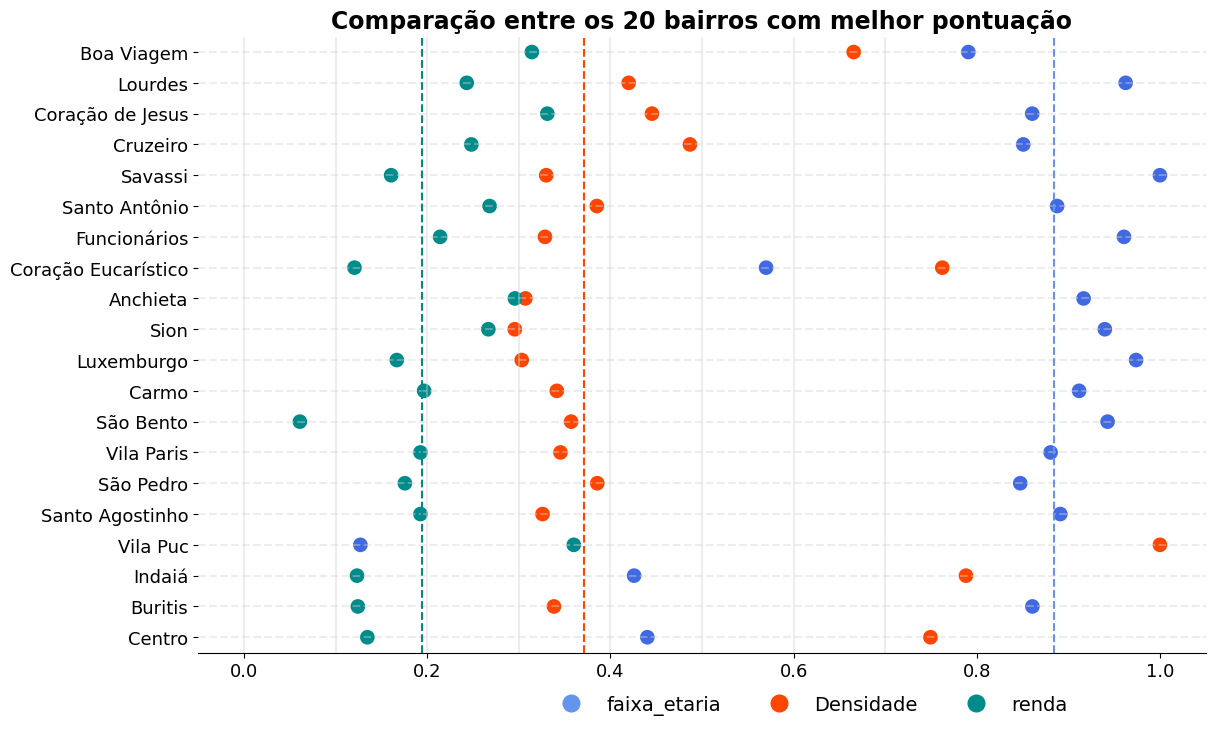

In [199]:
fig, ax = plt.subplots(1, 1, figsize=(13, 8))
plt.title('Comparação entre os 20 bairros com melhor pontuação',
          size=17, weight='heavy')

# main plots ----------------------------------------------

sns.pointplot(data=df_norm, x='renda', y='NM_BAIRRO', 
              color = 'RoyalBlue', join=False, ax=ax, markers='o', scale=1.2)

sns.pointplot(data=df_norm, x='faixa_etaria', y='NM_BAIRRO', 
              color = 'OrangeRed', join=False, ax=ax, markers='o', scale=1.2)

sns.pointplot(data=df_norm, x='Densidade', y='NM_BAIRRO', 
              color = 'DarkCyan', join=False, ax=ax, scale=1.2)


# vlines and hlines ----------------------------------------------

for i in range(len(df_norm)):
    plt.axhline(y=i, linestyle='--', alpha=0.4, color='lightgray')
    
for i in np.linspace(0, 0.7, 8):
    plt.axvline(x=i, linestyle='-', alpha=0.4, color='lightgray')
    
plt.axvline(df_norm['faixa_etaria'].median(),  color = 'OrangeRed', linestyle='--')
plt.axvline(df_norm['Densidade'].median(),  color = 'DarkCyan', linestyle='--')
plt.axvline(df_norm['renda'].median(),  color = 'CornflowerBlue', linestyle='--')



handles = [plt.Line2D([], [], color='CornflowerBlue', marker='o', linewidth=0, markersize=12),
           plt.Line2D([], [], color='OrangeRed', marker='o', linewidth=0, markersize=12),
           plt.Line2D([], [], color='DarkCyan', marker='o', linewidth=0, markersize=12)]

# ticks and legends ----------------------------------------------

ax.legend(handles=handles, labels=['faixa_etaria','Densidade','renda'],
         loc='lower right', ncol=3, fontsize=14,
         bbox_to_anchor=(0.88, -0.13), frameon=False)

ax.tick_params(axis='both', which='major', labelsize=13)

plt.xlabel('')  
plt.ylabel('')
sns.despine(left=True)

## 6 Plotagem distribuição de estabelecimentos no gráfico

#### 6.1 Descrição/Limpeza/tratamento

In [200]:
dados = apontador
dados = dados.drop(index=1).reset_index()
dados.head()

,index,nome,rua,numero,bairro,cidade,informacoes,informacoes_geo,lat,lon
0,2,"Camisa 10 - Restaurante, Bar & Cafeteria",Avenida Cristiano Machado,11833,Vila Clóris,Belo Horizonte - MG,"Avenida Cristiano Machado, 11833, Vila Clóris,...","(11833, Avenida Cristiano Machado, Parque São ...",-19.820676,-43.946807
1,3,Cafeteria da Fazenda,Rua Montes Claros,752,Anchieta,Belo Horizonte - MG,"Rua Montes Claros, 752, Anchieta, Belo Horizon...","(Rua Montes Claros, Anchieta, Regional Centro-...",-19.949414,-43.924792
2,4,Estação do Café - Funcionários,Avenida do Contorno,6548,Santo Antônio,Belo Horizonte - MG,"Avenida do Contorno, 6548, Santo Antônio, Belo...","(Avenida do Contorno, Santo Antônio, Regional ...",-19.940340,-43.937644
3,5,Estação do Café Cafeteria,Avenida Dos Andradas,367 364,Vera Cruz,Belo Horizonte - MG,"Avenida Dos Andradas, 367 364, Vera Cruz, Belo...","(Avenida dos Andradas, Vera Cruz, Regional Les...",-19.905178,-43.895547
4,8,Los Tanos Cafeteria Confeitaria e Massas - Jar...,Avenida Liége,188,Europa,Belo Horizonte - MG,"Avenida Liége, 188, Europa, Belo Horizonte - MG","(Avenida Liège, Jardim Europa, Europa, Venda N...",-19.799410,-43.972062


In [201]:
dados['point'] = dados.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
dados.head()

,index,nome,rua,numero,bairro,cidade,informacoes,informacoes_geo,lat,lon,point
0,2,"Camisa 10 - Restaurante, Bar & Cafeteria",Avenida Cristiano Machado,11833,Vila Clóris,Belo Horizonte - MG,"Avenida Cristiano Machado, 11833, Vila Clóris,...","(11833, Avenida Cristiano Machado, Parque São ...",-19.820676,-43.946807,POINT (-43.9468074 -19.8206759)
1,3,Cafeteria da Fazenda,Rua Montes Claros,752,Anchieta,Belo Horizonte - MG,"Rua Montes Claros, 752, Anchieta, Belo Horizon...","(Rua Montes Claros, Anchieta, Regional Centro-...",-19.949414,-43.924792,POINT (-43.9247918 -19.9494136)
2,4,Estação do Café - Funcionários,Avenida do Contorno,6548,Santo Antônio,Belo Horizonte - MG,"Avenida do Contorno, 6548, Santo Antônio, Belo...","(Avenida do Contorno, Santo Antônio, Regional ...",-19.940340,-43.937644,POINT (-43.937644 -19.9403395)
3,5,Estação do Café Cafeteria,Avenida Dos Andradas,367 364,Vera Cruz,Belo Horizonte - MG,"Avenida Dos Andradas, 367 364, Vera Cruz, Belo...","(Avenida dos Andradas, Vera Cruz, Regional Les...",-19.905178,-43.895547,POINT (-43.8955465 -19.9051779)
4,8,Los Tanos Cafeteria Confeitaria e Massas - Jar...,Avenida Liége,188,Europa,Belo Horizonte - MG,"Avenida Liége, 188, Europa, Belo Horizonte - MG","(Avenida Liège, Jardim Europa, Europa, Venda N...",-19.799410,-43.972062,POINT (-43.9720618 -19.79941)


In [202]:
dados_starbucks.head()

,Name,Fulladdress,Bairro,Municipality,Review Count,Average Rating,Latitude,Longitude
0,Starbucks Boulevard Shopping,"Av. dos Andradas - Santa Efigênia, Belo Horizo...",Santa Efigênia,Belo Horizonte - MG,444,3.9,-19.92,-43.91
1,Starbucks,"BR-356, 3049 - Belvedere, Belo Horizonte - MG,...",Belvedere,Belo Horizonte - MG,143,3.5,-19.97,-43.94
2,Starbucks,Avenida Cristiano Machado 4000 Quisque 103 e 1...,União,Belo Horizonte - MG,254,4.2,-19.87,-43.92
3,Starbucks - Shopping Cidade,"Rua dos Tupis, 337 - Centro, Belo Horizonte - ...",Centro,Belo Horizonte - MG,396,4.3,-19.92,-43.94
4,Starbucks,"Av. Presidente Carlos Luz, 3001 - Pampulha, Be...",Pampulha,Belo Horizonte - MG,25,3.7,-19.89,-43.96


#### 6.2 Transformação de coordenadas em variável única

In [203]:
dados_starbucks['point'] = dados_starbucks.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)

In [204]:
dados_starbucks

,Name,Fulladdress,Bairro,Municipality,Review Count,Average Rating,Latitude,Longitude,point
0,Starbucks Boulevard Shopping,"Av. dos Andradas - Santa Efigênia, Belo Horizo...",Santa Efigênia,Belo Horizonte - MG,444,3.9,-19.92,-43.91,POINT (-43.91 -19.92)
1,Starbucks,"BR-356, 3049 - Belvedere, Belo Horizonte - MG,...",Belvedere,Belo Horizonte - MG,143,3.5,-19.97,-43.94,POINT (-43.94 -19.97)
2,Starbucks,Avenida Cristiano Machado 4000 Quisque 103 e 1...,União,Belo Horizonte - MG,254,4.2,-19.87,-43.92,POINT (-43.92 -19.87)
3,Starbucks - Shopping Cidade,"Rua dos Tupis, 337 - Centro, Belo Horizonte - ...",Centro,Belo Horizonte - MG,396,4.3,-19.92,-43.94,POINT (-43.94 -19.92)
4,Starbucks,"Av. Presidente Carlos Luz, 3001 - Pampulha, Be...",Pampulha,Belo Horizonte - MG,25,3.7,-19.89,-43.96,POINT (-43.96 -19.89)
5,Starbucks,"Av. Vilarinho, 36 - Vila Cloris, Belo Horizont...",Vila Cloris,Belo Horizonte - MG,23,4.1,-19.82,-43.94,POINT (-43.94 -19.82)
6,Starbucks - Cidade Administrativa,"629X+4F - Serra Verde, Belo Horizonte - MG",Serra verde,Belo Horizonte - MG,4,5.0,-19.78,-43.95,POINT (-43.95 -19.78)
7,Starbucks at Home,"Av. Professor Mário Werneck, 1500 - Buritis, B...",Buritis,Belo Horizonte - MG,3,4.7,-19.96,-43.96,POINT (-43.96 -19.96)


In [205]:
dados_starbucks['point']

0    POINT (-43.91 -19.92)
1    POINT (-43.94 -19.97)
2    POINT (-43.92 -19.87)
3    POINT (-43.94 -19.92)
4    POINT (-43.96 -19.89)
5    POINT (-43.94 -19.82)
6    POINT (-43.95 -19.78)
7    POINT (-43.96 -19.96)
Name: point, dtype: object

In [206]:
# Defina uma função para converter as coordenadas em objetos Point
def to_geometry(coordenadas):
    return Point(coordenadas)

# Crie uma nova coluna "geometry" com os objetos geométricos correspondentes
dados_starbucks["geometry"] = dados_starbucks["point"].apply(to_geometry)

# Verifique o resultado
print(dados_starbucks)


                                Name  \
0       Starbucks Boulevard Shopping   
1                          Starbucks   
2                          Starbucks   
3        Starbucks - Shopping Cidade   
4                          Starbucks   
5                          Starbucks   
6  Starbucks - Cidade Administrativa   
7                  Starbucks at Home   

                                         Fulladdress          Bairro  \
0  Av. dos Andradas - Santa Efigênia, Belo Horizo...  Santa Efigênia   
1  BR-356, 3049 - Belvedere, Belo Horizonte - MG,...       Belvedere   
2  Avenida Cristiano Machado 4000 Quisque 103 e 1...           União   
3  Rua dos Tupis, 337 - Centro, Belo Horizonte - ...          Centro   
4  Av. Presidente Carlos Luz, 3001 - Pampulha, Be...        Pampulha   
5  Av. Vilarinho, 36 - Vila Cloris, Belo Horizont...     Vila Cloris   
6         629X+4F - Serra Verde, Belo Horizonte - MG     Serra verde   
7  Av. Professor Mário Werneck, 1500 - Buritis, B...         Bu

In [207]:
#dados_starbucks.dtypes

## 7 Mapa distribuição melhores bairros e concorrência
Criação variável ponderada (com raking dos melhores bairros) e plotagem junto com a localização de cafeterias em BH (mostrando a starbucks como principal concorrente)

#### 7.1 Normalização e junção dos dados

In [208]:
df_norm = df_norm.rename(columns={"NM_BAIRRO": "bairro"})

In [209]:
aux.head(2)

,ID,CD_GEOCODI,TIPO,CD_GEOCODB,NM_BAIRRO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,geometry,renda,faixa_etaria,Densidade
0,978,310620005620091,URBANO,310620005088,Boa Viagem,31062000562,CENTRO-SUL,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.93512 -19.92652, -43.93421 -19.9...",38.9,27.5,19421
1,977,310620005620090,URBANO,310620005088,Boa Viagem,31062000562,CENTRO-SUL,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.93512 -19.92652, -43.93411 -19.9...",38.9,27.5,19421


In [210]:
df_ponderada = aux[['NM_BAIRRO', 'renda', 'faixa_etaria', 'Densidade']]
df_ponderada.head(2)
df_ponderada1 = aux[['renda', 'faixa_etaria', 'Densidade']]


In [211]:
df_ponderada1.head()

,renda,faixa_etaria,Densidade
0,38.9,27.5,19421
1,38.9,27.5,19421
2,38.9,27.5,19421
3,38.9,27.5,19421
4,38.9,27.5,19421


In [212]:
# Instanciando o scaler MinMax
scaler = MinMaxScaler()
df_ponderada1[["renda", "faixa_etaria", "Densidade"]] = scaler.fit_transform(df_ponderada1[["renda", "faixa_etaria", "Densidade"]])
df_ponderada1.head()

,renda,faixa_etaria,Densidade
0,0.790811,0.785714,0.314256
1,0.790811,0.785714,0.314256
2,0.790811,0.785714,0.314256
3,0.790811,0.785714,0.314256
4,0.790811,0.785714,0.314256


In [213]:
df_norm = pd.concat([bairros, df_ponderada1], axis=1)
df_norm.head()

,NM_BAIRRO,renda,faixa_etaria,Densidade
0,Vila Rica,0.790811,0.785714,0.314256
1,Vila do Pombal,0.790811,0.785714,0.314256
2,Cidade Jardim Taquaril,0.790811,0.785714,0.314256
3,Vila Batik,0.790811,0.785714,0.314256
4,Pirineus,0.790811,0.785714,0.314256


In [214]:
aux.head()

,ID,CD_GEOCODI,TIPO,CD_GEOCODB,NM_BAIRRO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,geometry,renda,faixa_etaria,Densidade
0,978,310620005620091,URBANO,310620005088,Boa Viagem,31062000562,CENTRO-SUL,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.93512 -19.92652, -43.93421 -19.9...",38.9,27.5,19421
1,977,310620005620090,URBANO,310620005088,Boa Viagem,31062000562,CENTRO-SUL,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.93512 -19.92652, -43.93411 -19.9...",38.9,27.5,19421
2,2122,310620005620087,URBANO,310620005088,Boa Viagem,31062000562,CENTRO-SUL,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.93614 -19.93018, -43.93485 -19.9...",38.9,27.5,19421
3,2123,310620005620088,URBANO,310620005088,Boa Viagem,31062000562,CENTRO-SUL,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.93710 -19.92864, -43.93685 -19.9...",38.9,27.5,19421
4,2124,310620005620089,URBANO,310620005088,Boa Viagem,31062000562,CENTRO-SUL,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.93642 -19.92621, -43.93560 -19.9...",38.9,27.5,19421


In [215]:
aux.dtypes

ID                 int64
CD_GEOCODI        object
TIPO              object
CD_GEOCODB        object
NM_BAIRRO         object
CD_GEOCODS        object
NM_SUBDIST        object
CD_GEOCODD        object
NM_DISTRIT        object
CD_GEOCODM        object
NM_MUNICIP        object
NM_MICRO          object
NM_MESO           object
geometry        geometry
renda            float64
faixa_etaria     float64
Densidade          int64
dtype: object

In [216]:
merged_df = pd.merge(df_norm, aux, on="NM_BAIRRO")

In [217]:
merged_df.head(2)

,NM_BAIRRO,renda_x,faixa_etaria_x,Densidade_x,ID,CD_GEOCODI,TIPO,CD_GEOCODB,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,geometry,renda_y,faixa_etaria_y,Densidade_y
0,Vila Rica,0.790811,0.785714,0.314256,4254,310620005680048,URBANO,310620005202,31062000568,PAMPULHA,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.95304 -19.85474, -43.95295 -19.8...",23.04,12.57,6897
1,Vila do Pombal,0.790811,0.785714,0.314256,3107,310620005640206,URBANO,310620005061,31062000564,NORDESTE,310620005,BELO HORIZONTE,3106200,BELO HORIZONTE,BELO HORIZONTE,METROPOLITANA DE BELO HORIZONTE,"POLYGON ((-43.93975 -19.89595, -43.93911 -19.8...",2.46,13.93,35500


#### 7.2 Criação variável de ranking ponderada

In [218]:
merged_df['ponderada'] = (2 * merged_df['renda_y'] +  2 * merged_df['faixa_etaria_y'] +   merged_df['Densidade_y']) / 3

In [219]:
merged_df.dtypes

NM_BAIRRO           object
renda_x            float64
faixa_etaria_x     float64
Densidade_x        float64
ID                   int64
CD_GEOCODI          object
TIPO                object
CD_GEOCODB          object
CD_GEOCODS          object
NM_SUBDIST          object
CD_GEOCODD          object
NM_DISTRIT          object
CD_GEOCODM          object
NM_MUNICIP          object
NM_MICRO            object
NM_MESO             object
geometry          geometry
renda_y            float64
faixa_etaria_y     float64
Densidade_y          int64
ponderada          float64
dtype: object

In [220]:
aux.type

0       Polygon
1       Polygon
2       Polygon
3       Polygon
4       Polygon
         ...   
3876    Polygon
3877    Polygon
3878    Polygon
3879    Polygon
3880    Polygon
Length: 3881, dtype: object

In [221]:
#mudança tipo variável
merged_df = GeoDataFrame(merged_df)

merged_df.type

0       Polygon
1       Polygon
2       Polygon
3       Polygon
4       Polygon
         ...   
3876    Polygon
3877    Polygon
3878    Polygon
3879    Polygon
3880    Polygon
Length: 3881, dtype: object

### 7.3 Plotagem do mapa

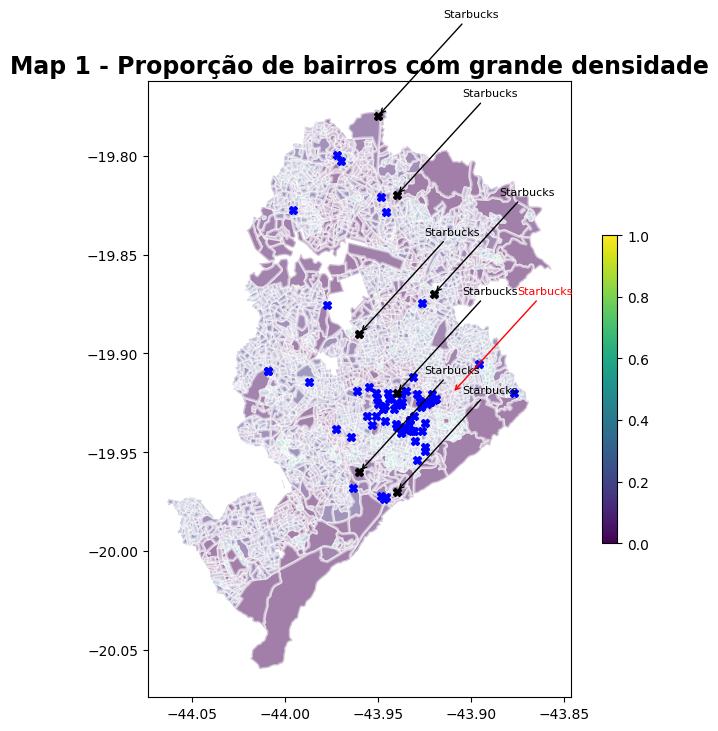

In [222]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

#plt.title('Map 1 - Proporção de pessoas com 5 salários mínimos ou mais', size=17, weight='heavy')
#mapa_cores = aux.plot(column='faixa_etaria', cmap='Spectral',
#                       edgecolor='white', linewidth=2, ax=ax, alpha=0.8)

plt.title('Map 1 - Proporção de bairros com grande densidade', size=17, weight='heavy')

# define o valor mínimo e máximo para a escala de cores
vmin = merged_df['ponderada'].min()
vmax = merged_df['ponderada'].max()


# cria a escala de cores
import matplotlib.colors as colors
wine_colormap = colors.ListedColormap(['#FFB6C1', '#FF69B4', '#FF1493', '#C71585', '#8B008B'])

mapa_cores = merged_df.plot(column='ponderada', cmap='viridis', edgecolor='white',
                       linewidth=2, ax=ax, alpha=0.5, vmin=vmin, vmax=vmax)


# criação da legenda
mapa_cores = cm.ScalarMappable(cmap='viridis')
#mapa_cores.set_array([-19.75, maximo])
legenda = plt.colorbar(mapa_cores, ax=ax, shrink=0.5)
#legenda.ax.set_ylabel('Proporção de adultos')


def plot_annotate(name, xy, xytext, color='black'):
    ax.annotate(text=name, xy=xy, xytext=xytext, size=8, arrowprops=dict(arrowstyle="->", color=color), 
                horizontalalignment='center', color=color)
    

for index, row in dados_starbucks.iterrows():
    #poligono = row['point']
    centroide = row['point']
    cor = 'red' if index == 0 else 'black' # definir uma cor diferente para o primeiro polígono
    #ax.add_patch(plt.Polygon(poligono.exterior, facecolor='none', edgecolor=cor, linewidth=2))
    plot_annotate(name='Starbucks', xy=centroide.coords[0], xytext=(centroide.x + 0.05, centroide.y + 0.05), color=cor)

def plot_annotate(xy, color='blue'):
    ax.plot(xy[0], xy[1], 'X', color=color, markersize=6)

for index, row in dados.iterrows():
    if index != 0:
        centroide = row['point']
        cor = 'blue'
        plot_annotate(xy=centroide.coords[0], color=cor) 

def plot_annotate(xy, color='black'):
    ax.plot(xy[0], xy[1], 'X', color=color, markersize=6)

for index, row in dados_starbucks.iterrows():
    if index != 0:
        centroide = row['point']
        cor = 'black'
        plot_annotate(xy=centroide.coords[0], color=cor)

plt.show()

###7.4 Insights

- A maioria dos estabelecimentos se concentra entre a parte central e a região suldeste da cidade.
- Há espaço para explorar outras regiões com menos concorrência, como o extremo leste até o extremo sul da cidade.

### Mapa folium com localização restaurantes

## 8 Conclusão


Os bairros foram analisados por vários critérios diferentes, de acordo com o público alvo: proporção de jovens, proorção de pessoas de alta renda, densidade demográfica e quantidade de estabelecimentos próximos.

Ao final, o bairro que apresentou as melhores condições foi o Boa Viagem

**Limitações:**

* As informações sobre bairros estão defasadas, já que o último censo foi feito em 2010; é necessário atualizar os dados assim que o novo estiver pronto (previsto para conclusão esse ou ano que vem);
* Houve várias informações faltantes no arquivo do IBGE que não poderiam ser imputadas.

**Algumas outras análises podem ser feitas para melhoras os resultados obtidos:**

* Análise dos custos fixos e variados associados ao bairro;
* Análise de dados de gênero e desemprego;
* Comparações entre capitais.